In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')
from typing import List

In [26]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

In [27]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [12, 12]

In [28]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [30]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

# Create Pseudo Data

In [31]:
seed = 42
test_size = 0.2

In [32]:
X_var = 1
y_var = 0.1

In [54]:
num_features = 1
num_noises = 100
num_data = 10000

In [55]:
X = (2*np.random.rand(num_data, num_features+num_noises)-1)*X_var
y_true = X[:, :1]**2
y_noise = np.random.randn(num_data, 1)*y_var
y = y_true+y_noise

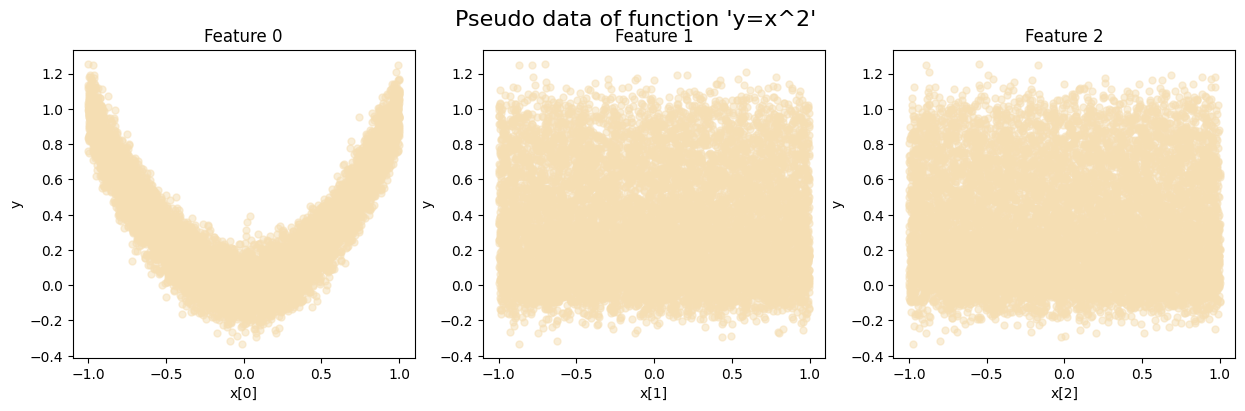

In [56]:
fig, axs = plt.subplots(nrows = math.ceil(num_features/3), ncols=3, figsize=(15, 4))
for i, ax in enumerate(axs.flat): 
    if i==0:
        fig.suptitle("Pseudo data of function 'y=x^2'", fontsize=16)
    x = X[:,i]
    ax.scatter(x, y, c='wheat', alpha=0.5)

    ax.set_title(f'Feature {i}')
    ax.set_xlabel(f'x[{i}]')
    ax.set_ylabel('y')
plt.show()

In [57]:
plt.close()

# Create MLP Regressor to Learn a Proper Function

In [58]:
class LinearBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
        )

    def forward(self, x: Tensor)-> Tensor:
        x = self.net(x)
        return x

In [59]:
class MLPRegressor(nn.Module):
    def __init__(self, in_channels: int, sizes: List[int], p: int=0.0):
        super().__init__()
        self.blocks = nn.ModuleList([
            LinearBlock(in_channels, sizes[0]),
            *[LinearBlock(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]
        ])
        self.dropout = nn.Dropout(p)
        self.project = nn.Linear(sizes[-1], 1)

    def forward(self, x: Tensor)-> Tensor:
        for block in self.blocks:
            x = block(x)
        x = self.dropout(x)
        x = self.project(x)
        return x

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [61]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0])
test_set = TensorDataset(Tensor(X_test), Tensor(y_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [62]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
regr = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
regr.to(device)
regr.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=101, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [65]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(regr.parameters(), 0.001)

In [66]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)

In [67]:
train(regr, train_loader, num_epochs, optimizer)

Train:   0%|          | 0/1000 [00:00<?, ?epoch/s]

In [68]:
y_pred = regr(Tensor(X_test).to(device)).detach().cpu().numpy()
score = mean_absolute_error(y_pred, y_test)

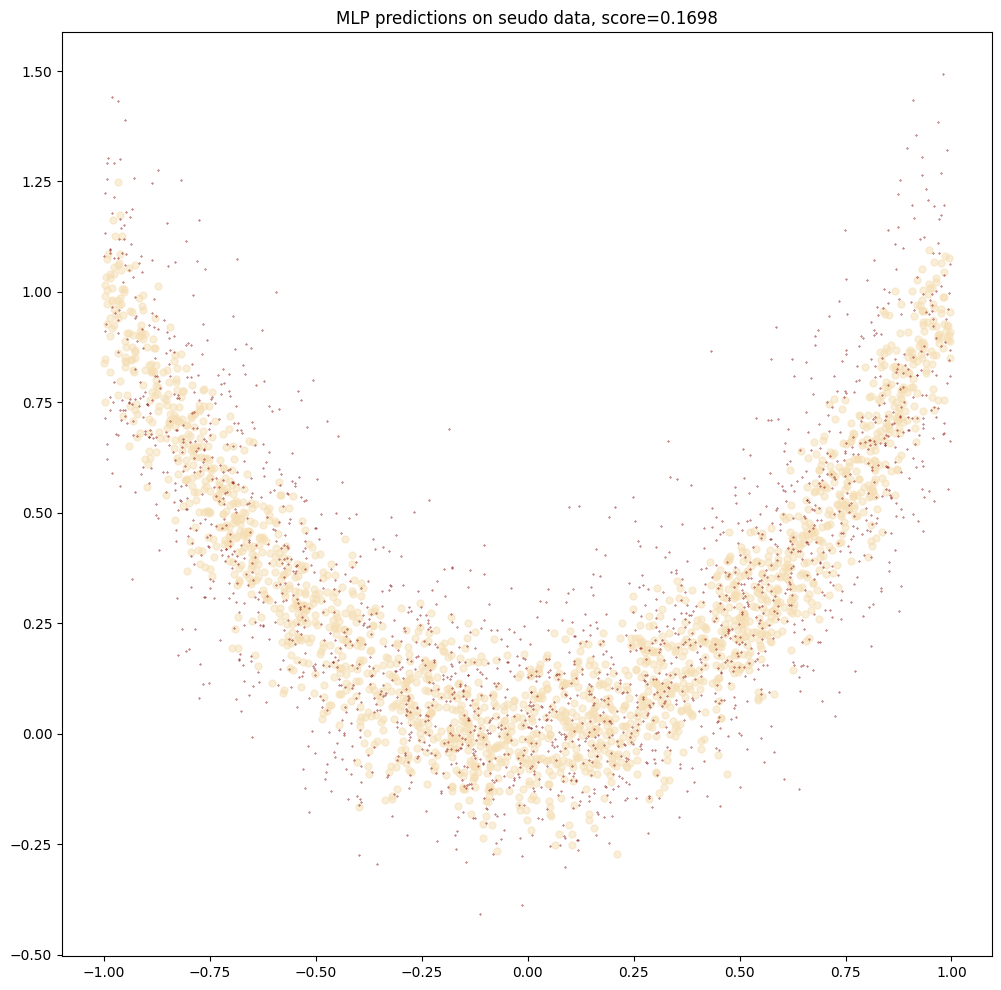

In [69]:
plt.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:.4f}")
plt.show()

In [70]:
plt.close()

# Memory and Time Cost

In [72]:
explainers = ['ig', 'sa', 'dl', 'fa']

In [73]:
times_keeper = []
memory_keeper = []

In [74]:
if torch.cuda.is_available():
    for explainer in explainers:
        start_time = time.time()
        torch.cuda.reset_peak_memory_stats()

        if explainer is 'ig':
            ig = IntegratedGradients(regr)
            ig_attr_test = ig.attribute(Tensor(X_test).to(device), n_steps=10)
        elif explainer is 'sa':
            sa = Saliency(regr)
            sa_attr_test = sa.attribute(Tensor(X_test).to(device))
        elif explainer is 'dl':
            dl = DeepLift(regr)
            dl_attr_test = dl.attribute(Tensor(X_test).to(device))
        elif explainer is 'fa':
            fa = FeatureAblation(regr)
            fa_attr_test = fa.attribute(Tensor(X_test).to(device))

        max_memory_used = torch.cuda.max_memory_allocated()
        time_cost = time.time() - start_time

        memory_keeper.append(max_memory_used)
        times_keeper.append(time_cost)

In [77]:
np.array(memory_keeper)/10**6

array([95.666176, 29.443584, 39.470592, 31.135744])

In [78]:
np.array(times_keeper)*1000

array([197.22938538,  16.58892632,  31.95905685,  33.26773643])